# Preparing data

We use the hourly data for bitcoin prices and volume from 2018-05-15 to 2022-03-01.

In [168]:
from data.handler import get_bitcoin_data

bitcoin_df = get_bitcoin_data()
bitcoin_df.head()

,unix,open,high,low,close,Volume BTC,Volume USD
0,1646092800,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06
1,1646089200,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06
2,1646085600,41657.23,44256.08,41650.29,42907.32,527.540571,2.263535e+07
3,1646082000,41917.09,41917.09,41542.60,41659.53,69.751680,2.905822e+06
4,1646078400,41361.99,41971.00,41284.11,41914.97,247.151654,1.035935e+07


In [169]:
print("Data entries: ", len(bitcoin_df))

Data entries:  33259


At first we calculate the Mahalanobis distance for each data point. We will use the distance to detect the outliers in the data price values.
The mahanalobis distance is calculated as follows:

$$
MD = \sqrt{(X - \mu)^T \Sigma^{-1} (X - \mu)}
$$

where $X$ is the data point, $\mu$ is the mean value and $\Sigma$ is the covariance matrix.

In [170]:
INTERVAL_DAYS = 100

In [171]:
from data.handler import apply_mahalanobis_interval, index_by_datetime

# Apply the Mahalanobis to the bitcoin data for intervals of given days
bitcoin_df = apply_mahalanobis_interval(bitcoin_df, interval_days=INTERVAL_DAYS)

# Set the datetime as the index
bitcoin_df = index_by_datetime(bitcoin_df)

bitcoin_df.head()

,unix,open,high,low,close,Volume BTC,Volume USD,interval,MD
datetime,,,,,,,,,
2022-03-01 00:00:00,1646092800,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06,14,2.714295
2022-02-28 23:00:00,1646089200,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06,14,2.676313
2022-02-28 22:00:00,1646085600,41657.23,44256.08,41650.29,42907.32,527.540571,2.263535e+07,14,2.602688
2022-02-28 21:00:00,1646082000,41917.09,41917.09,41542.60,41659.53,69.751680,2.905822e+06,14,2.295289
2022-02-28 20:00:00,1646078400,41361.99,41971.00,41284.11,41914.97,247.151654,1.035935e+07,14,2.351836


## Evaluating prices

The close prices and mean values used to calculate the Mahalanobis distance are plotted below. 

The red line represents the interval mean value for the Mahalanobis distance.

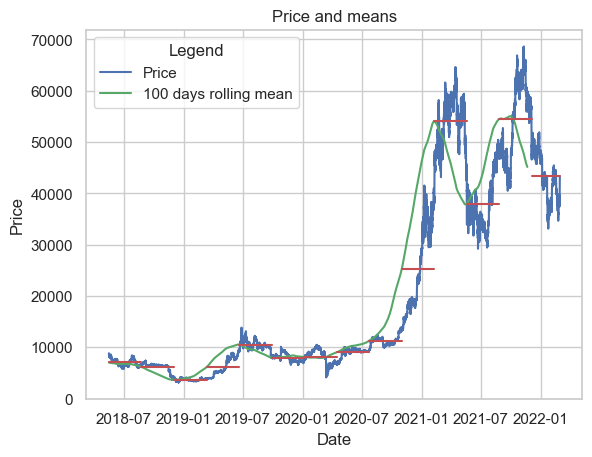

In [172]:
from data.plot import plot_price, plot_mahalanobis, plot_mahalanobis_distribution

plot_price(bitcoin_df, interval_days=INTERVAL_DAYS)

The mahalanobis distance is plotted below. Each color represents a different data interval.

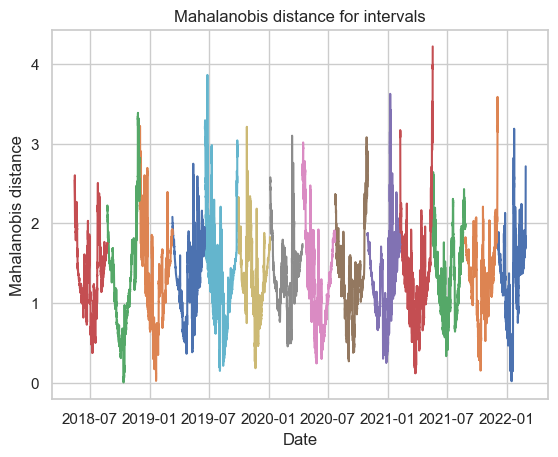

In [173]:
plot_mahalanobis(bitcoin_df, interval_days=INTERVAL_DAYS)

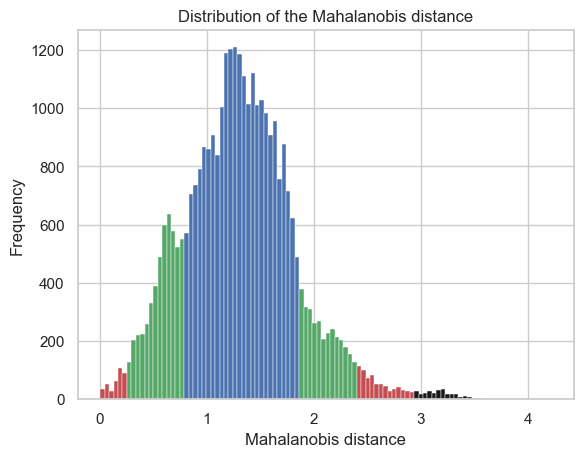

In [174]:
plot_mahalanobis_distribution(bitcoin_df)

### Evaluating prices based on Mahalanobis distance

In [175]:
STD_MAHALANOBIS = 3

In [176]:
from data.outliers import get_mahalanobis_outliers

# Get the outliers using the Mahalanobis distance
mahalanobis_outliers = get_mahalanobis_outliers(bitcoin_df, std_threshold=STD_MAHALANOBIS)

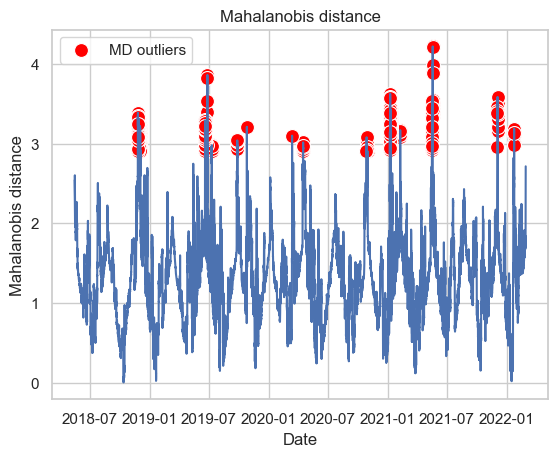

In [177]:
plot_mahalanobis(bitcoin_df, outliers=mahalanobis_outliers)

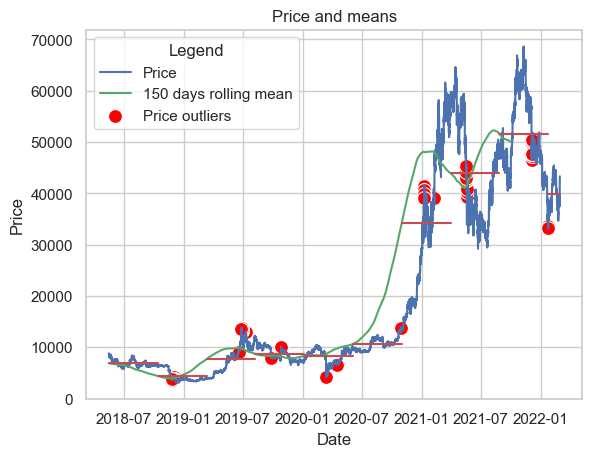

In [178]:
plot_price(bitcoin_df, outliers=mahalanobis_outliers)

## Evaluating volumes

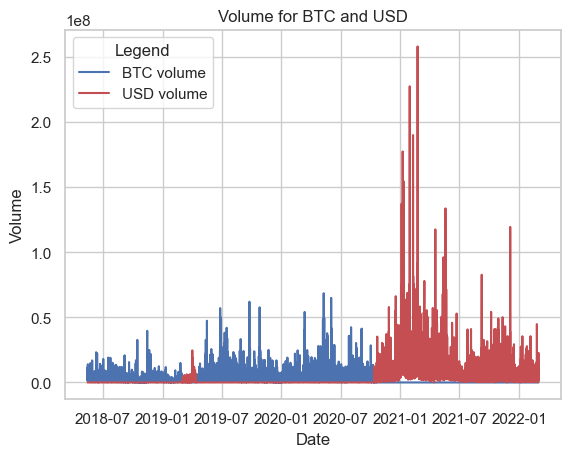

In [179]:
from data.plot import plot_volume, plot_price_volume_corelation
plot_volume(bitcoin_df)

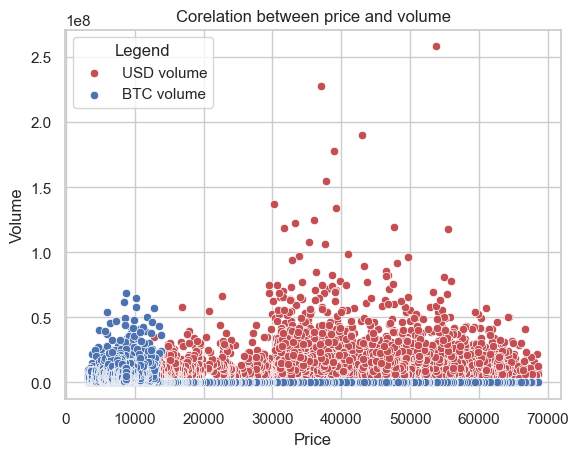

In [180]:
plot_price_volume_corelation(bitcoin_df)

### Price and volume correlation analysis

In [181]:
STD_VOLUME_BTC = 8
STD_VOLUME_USD = 8

In [182]:
from data.outliers import get_correlation_outliers

# Get the correlation outliers for the Volume BTC and Volume USD
correlation_outliers_BTC = get_correlation_outliers(bitcoin_df, data_column='Volume BTC', std_threshold=STD_VOLUME_BTC)
correlation_outliers_USD = get_correlation_outliers(bitcoin_df, data_column='Volume USD', std_threshold=STD_VOLUME_USD)

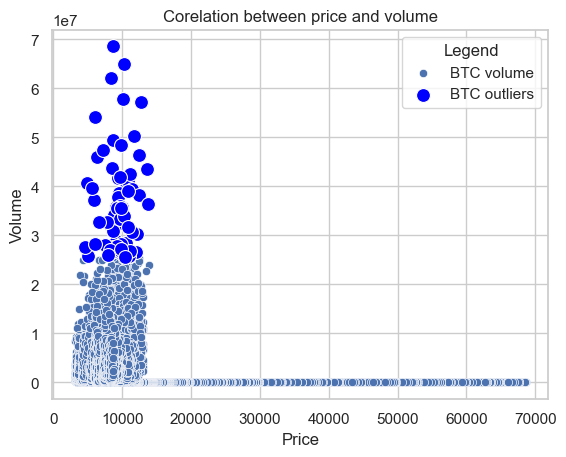

In [183]:
plot_price_volume_corelation(bitcoin_df, outliers_BTC=correlation_outliers_BTC, hide_USD=True)

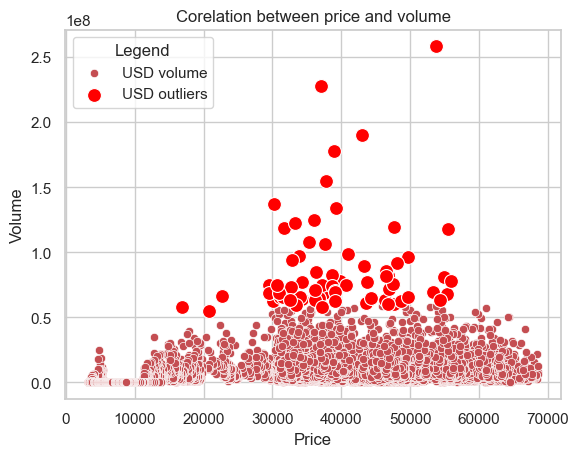

In [184]:
plot_price_volume_corelation(bitcoin_df, outliers_USD=correlation_outliers_USD, hide_BTC=True)

## Defining anomalies

We need to define anomalies for later use in the model. We will use the Mahalanobis distance, the volume and the price values to define the anomalies.

In [185]:
print("Mahalanobis Outliers: ", len(mahalanobis_outliers))
print("Volume BTC Outliers: ", len(correlation_outliers_BTC))
print("Volume USD Outliers: ", len(correlation_outliers_USD))

Mahalanobis Outliers:  306
Volume BTC Outliers:  66
Volume USD Outliers:  73


There are a few outliers that could be used as examples in our model. Let's now merge the Mahalanobis outliers with with the volume BTC - price correlation and the volume USD - price correlation outliers and see if we can find a pattern.

In [186]:
# Standard deviation threshold for merging the outliers

STD_MAHALANOBIS_MERGE = 3
STD_VOLUME_BTC_MERGE = 2
STD_VOLUME_USD_MERGE = 2

In [187]:
from data.outliers import get_merged_outliers

merged_outliers_volume_BTC = get_merged_outliers(bitcoin_df, data_column='Volume BTC', 
                                                 std_threshold_mahalanobis=STD_MAHALANOBIS_MERGE, 
                                                 std_threshold_correlation=STD_VOLUME_BTC_MERGE)

print("Mahalanobis & Volume BTC - price correlation Outliers: ", len(merged_outliers_volume_BTC))

Mahalanobis & Volume BTC - price correlation Outliers:  17


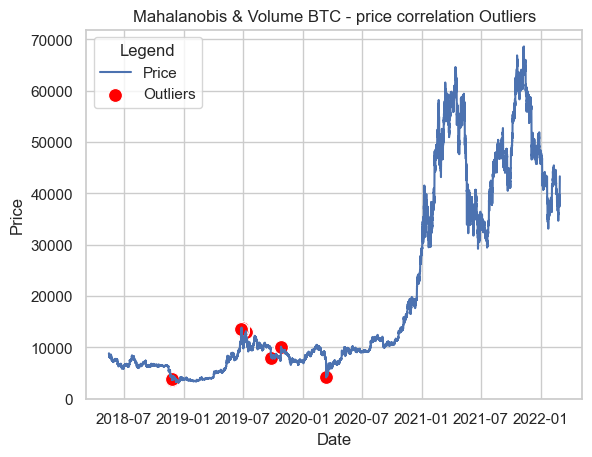

In [188]:
from data.plot import plot_outliers

plot_outliers(bitcoin_df, outliers=merged_outliers_volume_BTC, title="Mahalanobis & Volume BTC - price correlation Outliers")

In [189]:
merged_outliers_volume_USD = get_merged_outliers(bitcoin_df, data_column='Volume USD', 
                                                 std_threshold_mahalanobis=STD_MAHALANOBIS_MERGE, 
                                                 std_threshold_correlation=STD_VOLUME_USD_MERGE)

print("Mahalanobis & Volume USD - price correlation Outliers: ", len(merged_outliers_volume_USD))

Mahalanobis & Volume USD - price correlation Outliers:  55


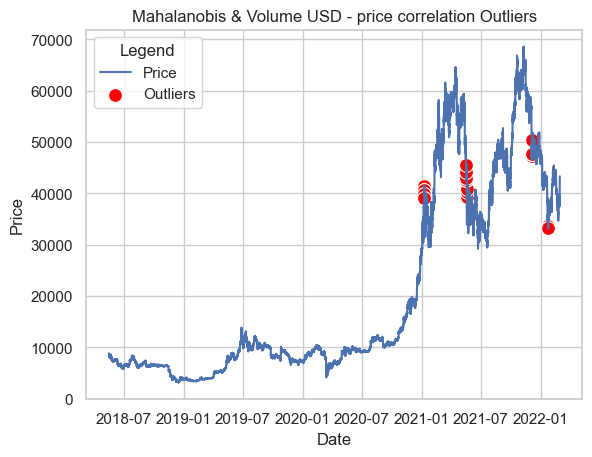

In [190]:
plot_outliers(bitcoin_df, outliers=merged_outliers_volume_USD, title="Mahalanobis & Volume USD - price correlation Outliers")

In [191]:
from data.outliers import concat_outliers

# Concatenate the "merged" outliers (Mahalanobis & Volume merge)
all_merged_outliers = concat_outliers(outliers_list=[merged_outliers_volume_BTC, merged_outliers_volume_USD])

print("Mahalanobis & Volume - price correlation Outliers: ", len(all_merged_outliers))

Mahalanobis & Volume - price correlation Outliers:  72


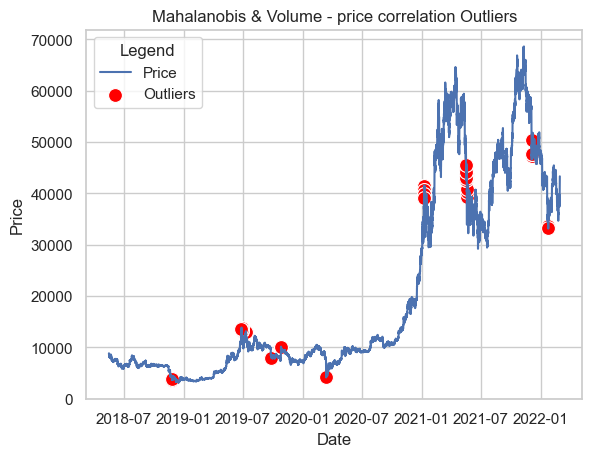

In [192]:
plot_outliers(bitcoin_df, outliers=all_merged_outliers, title="Mahalanobis & Volume - price correlation Outliers")

In [193]:
# Concatenate the volume outliers (Volume BTC and USD)
all_volume_outliers = concat_outliers(outliers_list=[correlation_outliers_BTC, correlation_outliers_USD])

print("Volume - price correlation Outliers: ", len(all_volume_outliers))

Volume - price correlation Outliers:  139


We need to add the anomalies to the data as a new feature for each set of outliers we want to use. We will create a few models and combine them in an ensemble model to predict the anomalies.

In [194]:
from data.handler import add_anomaly_column

# Create dataframes with the outliers and add the anomaly columns
bitcoin_df_merged = add_anomaly_column(bitcoin_df, outliers=all_merged_outliers)
bitcoin_df_mahalanobis = add_anomaly_column(bitcoin_df, outliers=mahalanobis_outliers)
bitcoin_df_volume = add_anomaly_column(bitcoin_df, outliers=all_volume_outliers)


print("Mahalanobis & Volume - price correlation anomalies: ", len(all_merged_outliers))
print("Mahalanobis anomalies: ", len(mahalanobis_outliers))
print("Volume - price correlation anomalies: ", len(all_volume_outliers))


Mahalanobis & Volume - price correlation anomalies:  72
Mahalanobis anomalies:  306
Volume - price correlation anomalies:  139


## Training datasets

Each of the following datasets has the same number of entries as the input data (33259 entries).

The features are:
- `timestamp`: Unix timestamp of the data point (seconds)
- `close`: Price of the bitcoin in USD
- `volume_btc`: Volume of bitcoin traded
- `volume_usd`: Volume of USD traded
- `anomaly`: Flag that indicates if the data point is an anomaly (True) or not (False)

The datasets are:
- `merged_dataset`: Original data with anomalies based on intersection of Mahalanobis outliers and volume outliers (volume BTC or volume USD) 
- `mahalanobis_dataset`: Original data with anomalies based on Mahalanobis outliers
- `volume_correlation_dataset`: Original data with anomalies based on volume - price correlation outliers

In [195]:
from data.handler import prepare_dataset

merged_dataset = prepare_dataset(bitcoin_df_merged)
merged_dataset.head()

,timestamp,close,volume_btc,volume_usd,anomaly
datetime,,,,,
2022-03-01 00:00:00,1646092800,43312.27,52.056320,2.254677e+06,False
2022-02-28 23:00:00,1646089200,43178.98,106.816103,4.612210e+06,False
2022-02-28 22:00:00,1646085600,42907.32,527.540571,2.263535e+07,False
2022-02-28 21:00:00,1646082000,41659.53,69.751680,2.905822e+06,False
2022-02-28 20:00:00,1646078400,41914.97,247.151654,1.035935e+07,False


In [196]:
mahalanobis_dataset = prepare_dataset(bitcoin_df_mahalanobis)
mahalanobis_dataset.head()

,timestamp,close,volume_btc,volume_usd,anomaly
datetime,,,,,
2022-03-01 00:00:00,1646092800,43312.27,52.056320,2.254677e+06,False
2022-02-28 23:00:00,1646089200,43178.98,106.816103,4.612210e+06,False
2022-02-28 22:00:00,1646085600,42907.32,527.540571,2.263535e+07,False
2022-02-28 21:00:00,1646082000,41659.53,69.751680,2.905822e+06,False
2022-02-28 20:00:00,1646078400,41914.97,247.151654,1.035935e+07,False


In [197]:
volume_correlation_dataset = prepare_dataset(bitcoin_df_volume)
volume_correlation_dataset.head()

,timestamp,close,volume_btc,volume_usd,anomaly
datetime,,,,,
2022-03-01 00:00:00,1646092800,43312.27,52.056320,2.254677e+06,False
2022-02-28 23:00:00,1646089200,43178.98,106.816103,4.612210e+06,False
2022-02-28 22:00:00,1646085600,42907.32,527.540571,2.263535e+07,False
2022-02-28 21:00:00,1646082000,41659.53,69.751680,2.905822e+06,False
2022-02-28 20:00:00,1646078400,41914.97,247.151654,1.035935e+07,False


In [198]:
all_dataset = merged_dataset.copy()
all_dataset['anomaly'] = merged_dataset['anomaly'] | mahalanobis_dataset['anomaly'] | volume_correlation_dataset['anomaly']
all_dataset.head()

,timestamp,close,volume_btc,volume_usd,anomaly
datetime,,,,,
2022-03-01 00:00:00,1646092800,43312.27,52.056320,2.254677e+06,False
2022-02-28 23:00:00,1646089200,43178.98,106.816103,4.612210e+06,False
2022-02-28 22:00:00,1646085600,42907.32,527.540571,2.263535e+07,False
2022-02-28 21:00:00,1646082000,41659.53,69.751680,2.905822e+06,False
2022-02-28 20:00:00,1646078400,41914.97,247.151654,1.035935e+07,False


## Training models

In [199]:
merged_dataset.head()

,timestamp,close,volume_btc,volume_usd,anomaly
datetime,,,,,
2022-03-01 00:00:00,1646092800,43312.27,52.056320,2.254677e+06,False
2022-02-28 23:00:00,1646089200,43178.98,106.816103,4.612210e+06,False
2022-02-28 22:00:00,1646085600,42907.32,527.540571,2.263535e+07,False
2022-02-28 21:00:00,1646082000,41659.53,69.751680,2.905822e+06,False
2022-02-28 20:00:00,1646078400,41914.97,247.151654,1.035935e+07,False


In [200]:
from sklearn.model_selection import train_test_split

def prepare_data(df):
    df = df[::-1]
    X = df[['close', 'volume_btc', 'volume_usd']]
    y = df['anomaly']
    return train_test_split(X, y, test_size=0.5, shuffle = False, stratify = None)

train_X_merged, test_X_merged, train_y_merged, test_y_merged  = prepare_data(merged_dataset)
train_X_mahalanobis, test_X_mahalanobis, train_y_mahalanobis, test_y_mahalanobis  = prepare_data(mahalanobis_dataset)
train_X_correlation, test_X_correlation, train_y_correlation, test_y_correlation  = prepare_data(volume_correlation_dataset)

train_X_all, test_X_all, train_y_all, test_y_all  = prepare_data(all_dataset)

In [201]:
print(train_y_merged.value_counts())
print(train_y_mahalanobis.value_counts())
print(train_y_correlation.value_counts())

print(train_y_all.value_counts())

anomaly
False    16612
True        17
Name: count, dtype: int64
anomaly
False    16493
True       136
Name: count, dtype: int64
anomaly
False    16594
True        35
Name: count, dtype: int64
anomaly
False    16462
True       167
Name: count, dtype: int64


In [202]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

clf1 = DecisionTreeClassifier()
clf2 = SVC(probability=True)
clf3 = LogisticRegression()

clf1a = clf1.fit(train_X_merged, train_y_merged)
clf1b = clf1.fit(train_X_mahalanobis, train_y_mahalanobis)
clf1c = clf1.fit(train_X_correlation, train_y_correlation)

In [203]:
from sklearn.ensemble import VotingClassifier


eclf = VotingClassifier(estimators=[
    ('one', clf1),
    ('two', clf2),
    ('three', clf3),
], voting='soft')

# Train the Voting Classifier
eclf.fit(train_X_correlation, train_y_correlation)

VotingClassifier(estimators=[('one', DecisionTreeClassifier()),
                             ('two', SVC(probability=True)),
                             ('three', LogisticRegression())],
                 voting='soft')


Merged scores

Acc: 0.9757666867107637
Preccision: 0.07352941176470588
Recall: 0.5454545454545454
F1: 0.12958963282937366


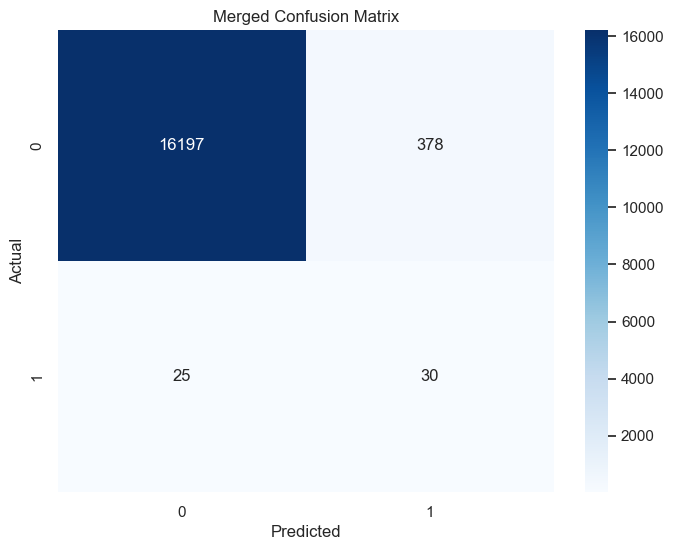


Mahalonobis scores

Acc: 0.9688514732411305
Preccision: 0.07352941176470588
Recall: 0.17647058823529413
F1: 0.10380622837370243


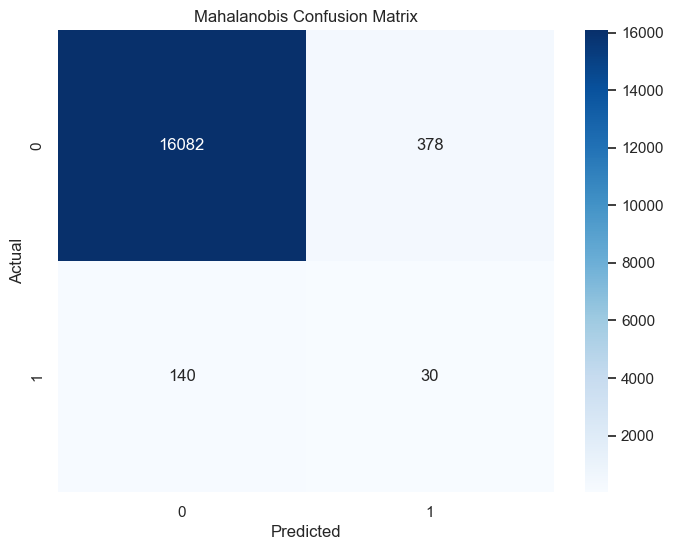


Correlation scores

Acc: 0.9815995189416716
Preccision: 0.25245098039215685
Recall: 0.9903846153846154
F1: 0.40234375


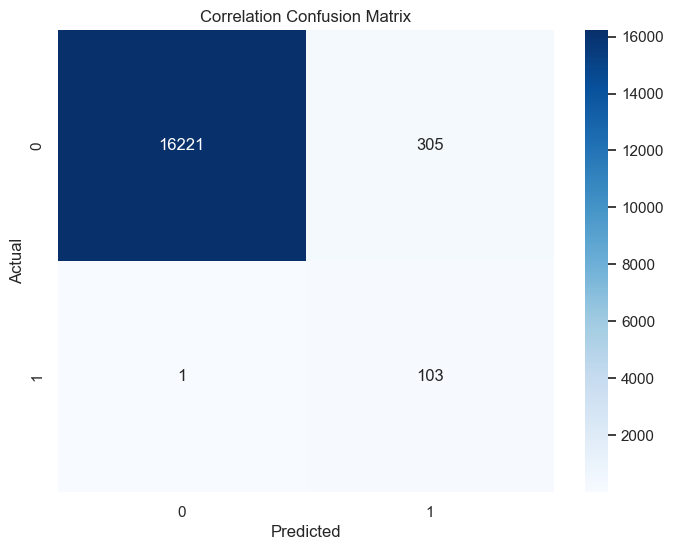


All scores

Acc: 0.9744437763078774
Preccision: 0.30392156862745096
Recall: 0.4679245283018868
F1: 0.3684992570579495


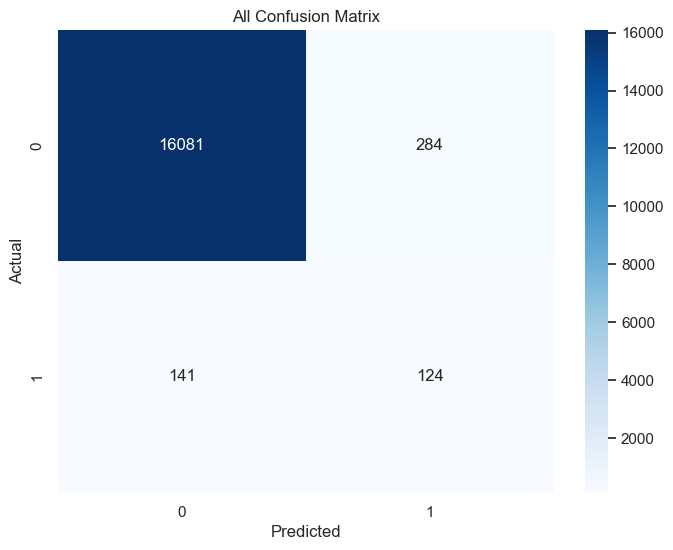

In [204]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# X_train = pd.concat([train_X_merged, train_X_mahalanobis, train_X_correlation], sort=True)
# y_train = pd.concat([train_y_merged, train_y_mahalanobis, train_y_correlation], sort=True)
# X_test = pd.concat([test_X_merged, test_X_mahalanobis, test_X_correlation], sort=True)
# y_test = pd.concat([test_y_merged, test_y_mahalanobis, test_y_correlation], sort=True)

X_train = train_X_all
y_train = train_y_all
X_test = test_X_all
y_test = test_y_all

eclf.fit(X_train, y_train)

y_pred = eclf.predict(X_test)
pred_y_merged = eclf.predict(test_X_merged)
pred_y_mahalanobis = eclf.predict(test_X_mahalanobis)
pred_y_correlation = eclf.predict(test_X_correlation)

def print_scores(y_test, y_pred, title):
    print(title)
    accuracy = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'Acc: {accuracy}')
    print(f'Preccision: {prec}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')

def plot_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()


print_scores(test_y_merged, pred_y_merged, "\nMerged scores\n")
plot_confusion_matrix(test_y_merged, pred_y_merged, "Merged Confusion Matrix")

print_scores(test_y_mahalanobis, pred_y_mahalanobis, "\nMahalonobis scores\n")
plot_confusion_matrix(test_y_mahalanobis, pred_y_mahalanobis, "Mahalanobis Confusion Matrix")

print_scores(test_y_correlation, pred_y_correlation, "\nCorrelation scores\n")
plot_confusion_matrix(test_y_correlation, pred_y_correlation, "Correlation Confusion Matrix")

print_scores(y_test, y_pred, "\nAll scores\n")
plot_confusion_matrix(y_test, y_pred, "All Confusion Matrix")


In [205]:
import pickle
    
with open('model.pkl', 'wb') as f:
    pickle.dump(eclf, f)


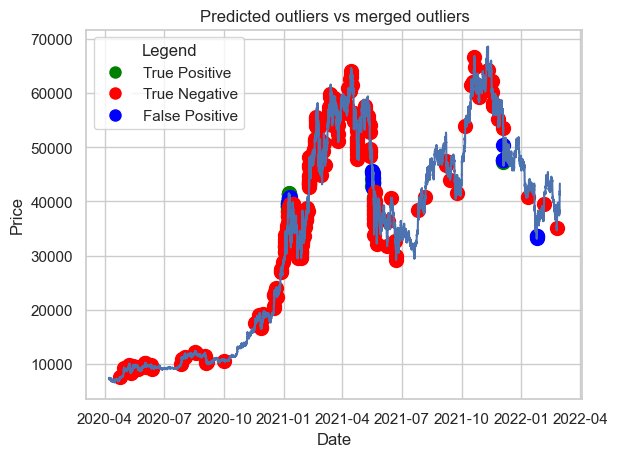

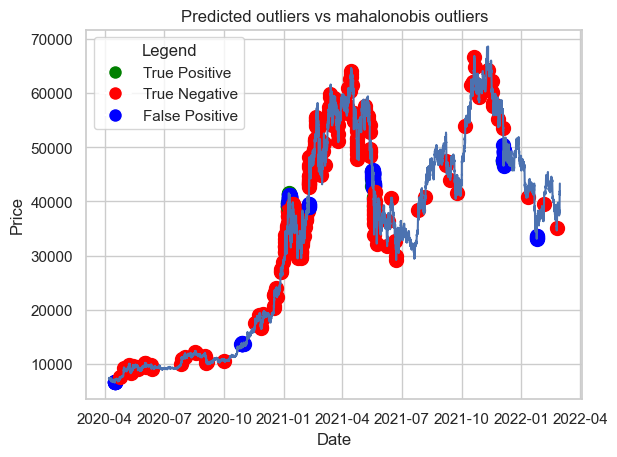

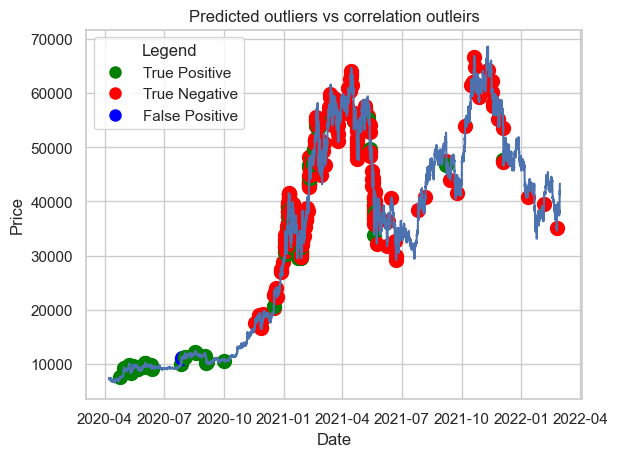

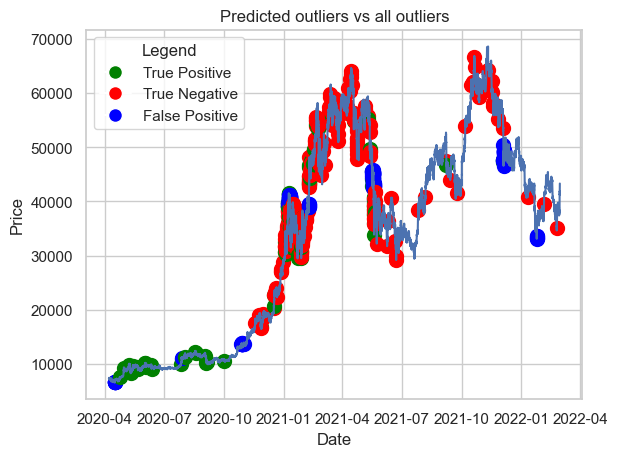

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_outliers_with_color(df: pd.DataFrame, y_test: pd.Series, outliers: np.ndarray, title: str):
    sns.set_theme(style="whitegrid")
    
    # Plot the price data
    sns.lineplot(data=df, x=df.index, y='close', color='b', label='Price')
    
    # Determine the colors based on outliers (y_pred) and y_test
    colors = ['blue'] * len(outliers)  # Default to blue
    for i in range(len(outliers)):
        if outliers[i] and y_test.iloc[i]:
            colors[i] = 'green'
        elif outliers[i] and not y_test.iloc[i]:
            colors[i] = 'red'
        elif not outliers[i] and y_test.iloc[i]:
            colors[i] = 'blue'  # Both False condition, kept as blue as default

    # Plot the points with different colors based on the conditions
    for i in range(len(outliers)):
        if outliers[i] or y_test.iloc[i]:  # Plot only if it's an outlier or true test label
            plt.scatter(x=df.index[i], y=df['close'].iloc[i], color=colors[i], marker='o', s=100)

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(title)
    
    # Create custom legend
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='True Positive'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='True Negative'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='False Positive'),
    ]
    plt.legend(handles=handles, title='Legend')
    plt.show()
 

plot_outliers_with_color(test_X_merged, test_y_merged, pred_y_merged, "Predicted outliers vs merged outliers")
plot_outliers_with_color(test_X_mahalanobis, test_y_mahalanobis, pred_y_mahalanobis, "Predicted outliers vs mahalonobis outliers")
plot_outliers_with_color(test_X_correlation, test_y_correlation, pred_y_correlation, "Predicted outliers vs correlation outleirs")
plot_outliers_with_color(X_test, y_test, y_pred, "Predicted outliers vs all outliers")